In [1]:
import numpy as np
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_node_grid
from scipy.optimize import fsolve, root
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
#Set up model
mg = RasterModelGrid((100,150),100)
h = mg.add_zeros('node', 'hydraulic__head', noclobber=False)#,h, units='m',noclobber=False)
h = np.random.rand(mg.number_of_nodes)
Q = mg.add_zeros('link', 'Q',noclobber=False)
net_node_flux = mg.add_ones('node', 'net_node_flux', noclobber=False)
#set boundary node head
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
#mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 1.
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print "Number of links = ", mg.number_of_links
print "Number of nodes = ", mg.number_of_nodes
print "Number of active links = ", mg.number_of_active_links
print "Number of core nodes = ", mg.number_of_core_nodes

Number of links =  29750
Number of nodes =  15000
Number of active links =  29254
Number of core nodes =  14504


In [6]:
#Calculate flow in network
max_tol = 0.001
tol = 1.
nstep = 1
while tol>max_tol:
    a=2.
    r=1.
    Q_ij = Q[links][mg.core_nodes]*mg.active_link_dirs_at_node[mg.core_nodes]
    F = Q_ij.sum(axis=1)*(1.-1./a)
    A_ij = zeros([n_core, n_core])
    for i, this_node in enumerate(mg.core_nodes):
        #calculate diagonal term in A matrix
        node_Qs = Q_ij[i]
        A_ii = 0.
        for link_Q in node_Qs:
            if link_Q != 0:
                A_ii += 1./(a*r*np.fabs(link_Q)**(a-1.))
        A_ij[i][i] = A_ii
        #loop through node links to calculate off-diagonal terms in A
        for this_link in links[this_node]:
            if this_link >= 0:#Ignore -1 cases, which indicate no link
                neighbor_node = mg.node_at_link_head[this_link]
                #Check whether we have the neighbor node
                if neighbor_node == this_node:
                    #neighbor is at tail, not head
                    neighbor_node = mg.node_at_link_tail[this_link]
                #Make sure this neighbor is not a boundary node (these are treated differently)
                if not mg.node_is_boundary(neighbor_node):
                    #Get proper j index for Array (neighbor core node number)
                    j = where(mg.core_nodes==neighbor_node)[0][0]
                    A_ij[i][j] = -1./(a*r*fabs(Q[this_link])**(a-1))
                else:#if boundary add term to F
                    if Q[this_link]!=0:#Check whether this is a closed boundary
                        F[i] += 1./(a*r*fabs(Q[this_link])**(a-1))*h[neighbor_node]
    #Turn A into sparse matrix
    A_csr = csr_matrix(A_ij)
    ##Solve linear system for new approximation of heads
    h[mg.core_nodes] = spsolve(A_csr,F)
    dQ= -(1./a)*Q[mg.active_links] - 1./(a*r*np.fabs(Q[mg.active_links])**(a-1)) * (mg.calc_diff_at_link(h)[mg.active_links])
    Q[mg.active_links] +=  dQ
    tol = sum(np.fabs(dQ))/sum(np.fabs(Q[mg.active_links]))
    print "Number of steps =", nstep, "tolerance =", tol
    nstep += 1

Number of steps = 1 tolerance = 0.936794542785
Number of steps = 2 tolerance = 0.825759664841
Number of steps = 3 tolerance = 0.673275737816
Number of steps = 4 tolerance = 0.446744119625
Number of steps = 5 tolerance = 0.25658240247
Number of steps = 6 tolerance = 0.146743619413
Number of steps = 7 tolerance = 0.0819131859178
Number of steps = 8 tolerance = 0.044426269671
Number of steps = 9 tolerance = 0.0213831683848
Number of steps = 10 tolerance = 0.00881993752615
Number of steps = 11 tolerance = 0.00329532607803
Number of steps = 12 tolerance = 0.00125044599502
Number of steps = 13 tolerance = 0.000449046385261


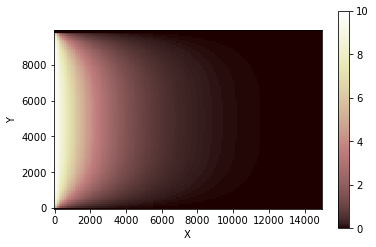

In [7]:
imshow_node_grid(mg, h)
#print "h=", h
#print "Q=",Q
#mg.calc_net_flux_at_node(Q, out=net_node_flux)
#print "net node flux = ", net_node_flux[mg.core_nodes]